In [1]:
import numpy as np
import cv2
import glob
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


# Calibrating Cmaera
# parameters: image_path - where images used to calibrate camera# pickle_file - saved calibrated data
# pickle_file - saved calibrated data file 
# return: mtx, dist, img_size
def calibrate_camera(image_path, pickle_file):
    # check if pickle file is not valid file then calibrate the camera
    # and save the calibrated data in pickle_file
    if not os.path.isfile(image_path+'/'+pickle_file):
        print('picke file does not exist')
        # initialize objpoints (3D real world space) and imgpoints (2D image plane)
        objpoints = []
        imgpoints = []

        # check dimension of chessboard images to initialize individual object point
        # the camera images in camera_cal folder does not seems to capture 
        # constant chessboard dimension and I am not getting treturn true from 
        # find chessboard corenr from every image so I have to change the dimension
        # of chessboard images to find the corners [(9,6), (8,6), (9,5), (9,4) (7,6), (5,6)]

        objp1 = np.zeros((9*6,3), np.float32)
        objp1[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
        objp2 = np.zeros((8*6,3), np.float32)
        objp2[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)
        objp3 = np.zeros((9*5,3), np.float32)
        objp3[:,:2] = np.mgrid[0:9, 0:5].T.reshape(-1,2)
        objp4 = np.zeros((9*4,3), np.float32)
        objp4[:,:2] = np.mgrid[0:9, 0:4].T.reshape(-1,2)
        objp5 = np.zeros((7*6,3), np.float32)
        objp5[:,:2] = np.mgrid[0:7, 0:6].T.reshape(-1,2)
        objp6 = np.zeros((5*6,3), np.float32)
        objp6[:,:2] = np.mgrid[0:5, 0:6].T.reshape(-1,2)

        images = glob.glob(image_path+'/calibration*.jpg')

        for idx, fname in enumerate(images):
            # read in image file
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # find the chessboard corners through all those dimensions
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            objp = objp1
            if not ret:
                ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
                objp = objp2
            if not ret:
                ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
                objp = objp3
            if not ret:
                ret, corners = cv2.findChessboardCorners(gray, (9,4), None)
                objp = objp4
            if not ret:
                ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
                objp = objp5
            if not ret:
                ret, corners = cv2.findChessboardCorners(gray, (5,6), None)
                objp = objp6

            # If found add object points and image points
            if ret == True:
                # print('found object points and image points')
                objpoints.append(objp)
                imgpoints.append(corners)
                img_size = (img.shape[1], img.shape[0])
                
                # draw chessboard corner
                cv2.drawChessboardCorners(img, (corners.shape[1],corners.shape[0]), corners, ret)
                write_name = 'output_images/corners/corners'+str(idx)+'.jpg'
                cv2.imwrite(write_name, img)
                # calibrate camera
                ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                                    imgpoints, 
                                                                    img_size, 
                                                                    None, 
                                                                    None)

        # save the data in pickel file for later use (we don't worry about rvecs and tvecs)
        dist_pickle = {}
        dist_pickle["img_size"] = img_size
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump(dist_pickle, open(image_path+"/"+pickle_file, "wb"))
        # print('saved distortion data to pickled file')

    else:
        # use the saved data 
        print('picke file exists')
        with open(image_path+"/"+pickle_file, 'rb') as pkf:
            data = pickle.load(pkf)
            img_size = data["img_size"]
            mtx = data["mtx"]
            dist = data["dist"]
            # print('loaded pickle distortion file')

    return mtx, dist, img_size

#### Using CameraCalibrator Object
A couple of celles below have generation of the original images that were given, corners images and undistorted images together, and example of how to use CameraCalibrator class.

In [2]:
# undistort the camera image
# parameters: img - images to undistort
# mtx, dist - calibrated data returned from calibrate_camera()
# return: undistorted image
def undistort_image(img, mtx, dist, img_size):
    img = cv2.imread(img)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [3]:
# calbrate the camera
mtx, dist, img_size = calibrate_camera('camera_cal', 'dist_pickle.p')

'''
dst = undistort_image(img_path, mtx, dist, img_size)
write_name = output_path+'/undistorted1.jpg'
cv2.imwrite(write_name, dst)
'''
# undistort all the images and save it in output_images/undistorted/ folder
images = glob.glob('camera_cal/calibration*.jpg')
for idx, fname in enumerate(images):
    # read in image file
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = 'output_images/undistorted/undistorted'+str(idx)+'.jpg'
    cv2.imwrite(write_name,dst)

picke file exists


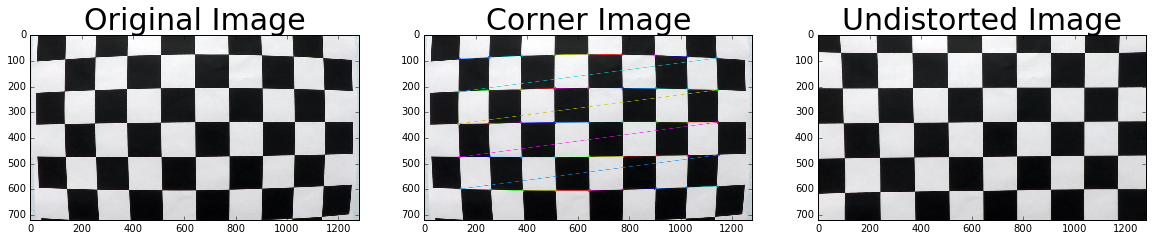

In [4]:
# visuallizing the distorted, corner and undistorted images
org_img = cv2.imread('camera_cal/calibration1.jpg')
corner = cv2.imread('output_images/corners/corners0.jpg')
dst = cv2.imread('output_images/undistorted/undistorted0.jpg')
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(org_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(corner)
ax2.set_title('Corner Image', fontsize=30)
ax3.imshow(dst)
ax3.set_title('Undistorted Image', fontsize=30)

In [5]:
# read images from test_images folder then undistort them and write the outputs in output_images folder
images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    # read in image file
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = 'output_images/test_images/undistorted_test'+str(idx)+'.jpg'
    cv2.imwrite(write_name,dst)

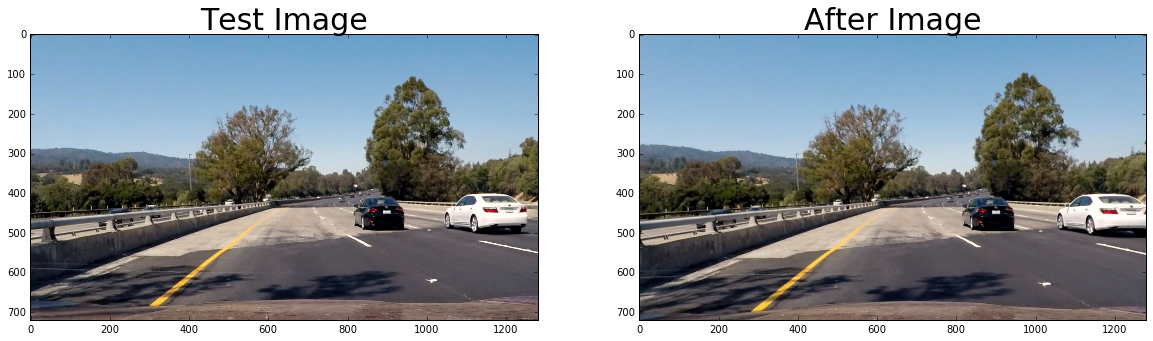

In [6]:
# visuallizing the test images side by side
import matplotlib.image as mpimg
test_img = mpimg.imread('test_images/test4.jpg')
after = mpimg.imread('output_images/test_images/undistorted_test3.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Test Image', fontsize=30)
ax2.imshow(after)
ax2.set_title('After Image', fontsize=30)

#### Thresholding

In [7]:
# Gradient Orientation Threshold using Sobel Operators
# parameters: image, gradient orientation, kernel size and threshold min/max
# return: binary_output of the gradient oreintation image
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    # binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # using cv2.threshold function
    ret, binary_output = cv2.threshold(scaled_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)

    # Return the result
    return binary_output

# Magnitude of gradient Threshold 
# parameters: image, kernel size and magnitude threshold min/max
# return: binary_output of the magnitude gradient image
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

# Directional gradient Threshold 
# parameters: image, kernel size and directional threshold range
# return: binary_output of the directional gradient image
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# S-channel thresholds of HLS
# parameters: image, and threshold min/max
def hls_select(img, thresh=(0, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    return binary_output

# hsv yelloe and white thrshold
# parameter: image 
def hsv_threshold(img):
    # convet to hsv space
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # yellow mask
    yellow_min = np.array([15, 100, 120], np.uint8)
    yellow_max = np.array([80, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(img, yellow_min, yellow_max)

    # white mask
    white_min = np.array([0, 0, 200], np.uint8)
    white_max = np.array([255, 30, 255], np.uint8)
    white_mask = cv2.inRange(img, white_min, white_max)

    binary_output = np.zeros_like(img[:, :, 0])
    binary_output[((yellow_mask != 0) | (white_mask != 0))] = 1

    # filtered = img
    # filtered[((yellow_mask == 0) & (white_mask == 0))] = 0

    return binary_output

# combining all the thresholding binary 
# parameter: img 
def combined_threshold(img):

    ksize = 15
    # directional gradient
    dir_binary = dir_threshold(img, ksize, thresh=(0.7, 1.2))
    # magnitude gradient
    mag_binary = mag_thresh(img, ksize, mag_thresh=(50, 255))
    # s channel binary
    hls_binary = hls_select(image, (90,255))

    hsv_binary = hsv_threshold(img)

    # combine together
    combined = np.zeros_like(dir_binary)
    # combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
    combined[((hsv_binary == 1) & ((mag_binary == 1) | (dir_binary == 1)))] = 1

    return combined

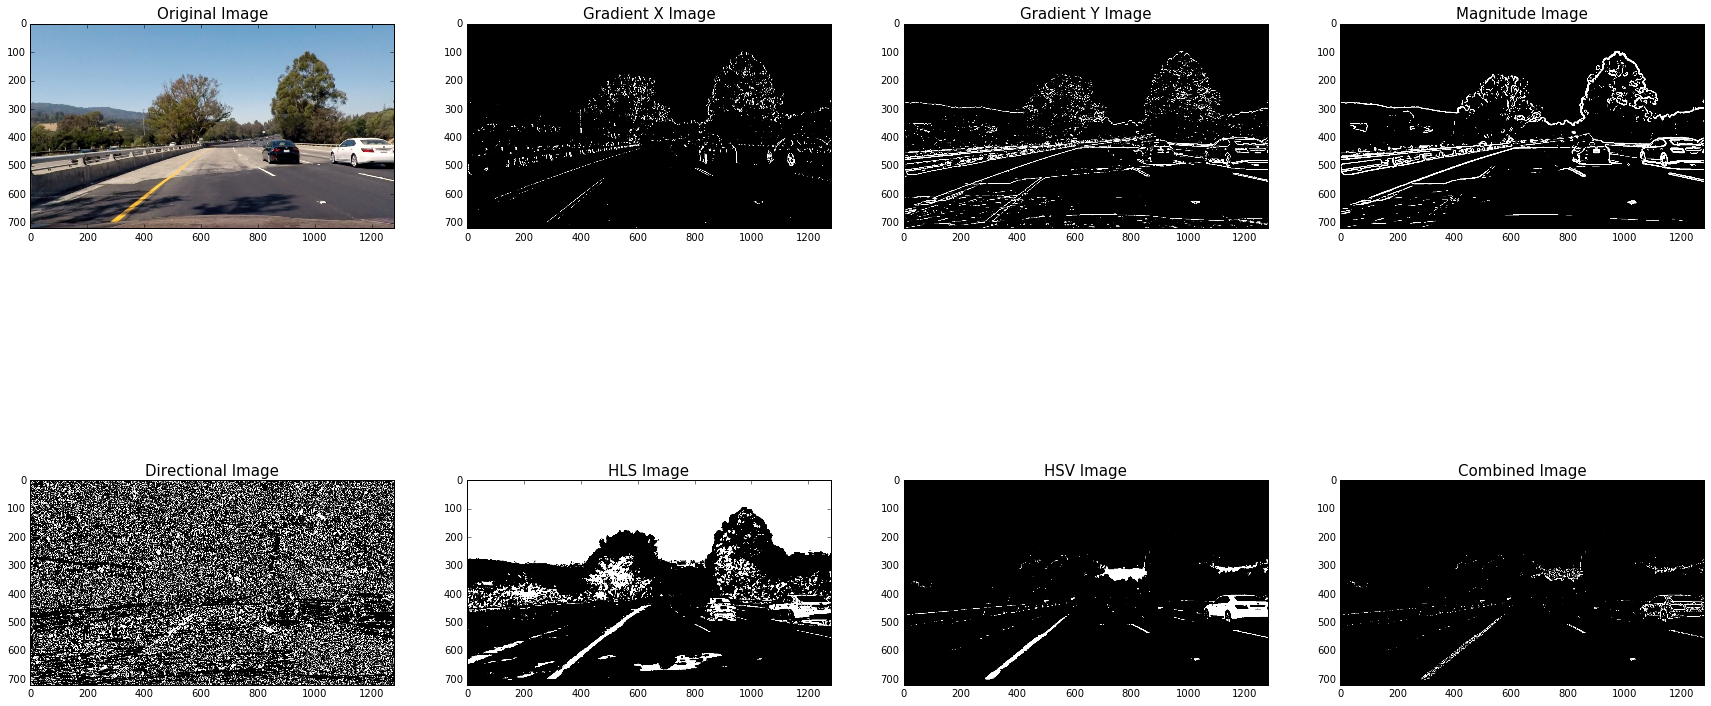

In [8]:
# choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# load image
# image = cv2.imread('output_images/test_images/undistorted_test3.jpg')
image = mpimg.imread('output_images/test_images/undistorted_test3.jpg')

# Apply each of the thresholding functions
# gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
# grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 150))
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(40, 150))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.2))
# hls_binary = hls_select(image, (88,190))
hls_binary = hls_select(image, (90,255))

hsv_binary = hsv_threshold(image)

combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
# combined[((gradx > 0) & (grady > 0)) | ((mag_binary > 0) & (dir_binary > 0)) | (hls_binary > 0)] = 1
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((hsv_binary == 1) & ((mag_binary == 1) | (dir_binary == 1)))] = 1

image = mpimg.imread('output_images/test_images/undistorted_test3.jpg')
# plt.imshow(image, cmap='gray')

f, ((ax1, ax2,ax3,ax4), (ax5, ax6,ax7, ax8)) = plt.subplots(2, 4, figsize=(30,15))
# f.tight_layout()
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Gradient X Image', fontsize=15)
ax3.imshow(grady, cmap='gray')
ax3.set_title('Gradient Y Image', fontsize=15)
ax4.imshow(mag_binary, cmap='gray')
ax4.set_title('Magnitude Image', fontsize=15)
ax5.imshow(dir_binary, cmap='gray')
ax5.set_title('Directional Image', fontsize=15)
ax6.imshow(hls_binary, cmap='gray')
ax6.set_title('HLS Image', fontsize=15)
ax7.imshow(hsv_binary, cmap='gray')
ax7.set_title('HSV Image', fontsize=15)
ax8.imshow(combined, cmap='gray')
ax8.set_title('Combined Image', fontsize=15)

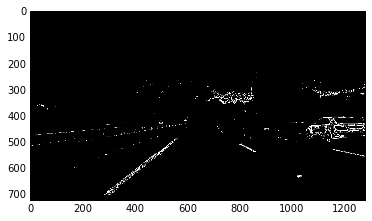

In [9]:
# test combined function
# load image
image = mpimg.imread('output_images/test_images/undistorted_test3.jpg')
combined = combined_threshold(image)
plt.imshow(combined, cmap='gray')

#### Perspective Transform

In [10]:
import pickle
with open('camera_cal/dist_pickle.p', 'rb') as pkf:
            data = pickle.load(pkf)
            img_size = data["img_size"]
'''            
SOURCE = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
DESTINATION = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
'''
SOURCE = np.float32(
            [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
            [((img_size[0] / 6)  + 47), img_size[1] - 40 ],
            [(img_size[0] * 5 / 6) - 26, img_size[1] - 40],
            [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
DESTINATION = np.float32(
        [[(img_size[0] / 4) - 60, 0],
        [(img_size[0] / 4) - 60, img_size[1]],
        [(img_size[0] * 3 / 4) + 80, img_size[1]],
        [(img_size[0] * 3 / 4) + 80, 0]])

# compute perspective transform and warp image
# parameters: img - undistorted image
# src - four source points
# dst - foour dst points
def warp_image(img, src=SOURCE, dst=DESTINATION):
    # need to convert gray scale?
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    return warped, M

# compute inverse perspective transform and unwarp image
# parameters: img - undistorted image
# src - four source points
# dst - foour dst points 
def unwarp_image(img, dst=DESTINATION, src=SOURCE):
    # need to convert gray scale?
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    return unwarped, Minv


[[ -6.18705434e-01  -1.51801558e+00   1.03238810e+03]
 [ -7.10542736e-15  -2.02571934e+00   9.31830895e+02]
 [ -1.10588622e-17  -2.38083794e-03   1.00000000e+00]]


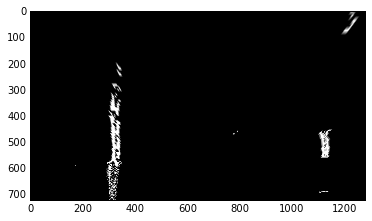

In [11]:
binary_warped, M = warp_image(combined)
print(M)
plt.imshow(binary_warped, cmap='gray')

[[  1.53846154e-01  -7.49952499e-01   5.40000000e+02]
 [ -2.44249065e-15  -4.93651749e-01   4.60000000e+02]
 [ -3.46944695e-18  -1.17530486e-03   1.00000000e+00]]


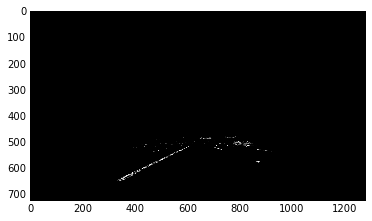

In [12]:
unwarped, Minv = unwarp_image(combined)
print(Minv)
plt.imshow(unwarped, cmap='gray')

#### Lane Line Fitting

In [13]:
# fitting the left and right lane lines using histogram and polyfit sliding window methods
# support code is ported from udacity lecture
# parameters: img - warped image
# return: left_fit, right_fit - second order polynomial
def fit_polynomial(img):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds

/Users/raymondlinn/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 0)

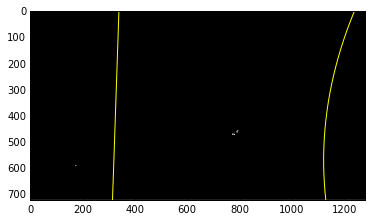

In [14]:
left_fit, right_fit, left_lane_inds, right_lane_inds = fit_polynomial(binary_warped)
# for visualizing
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Generate x and y values for plotting
fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720,)


(720, 0)

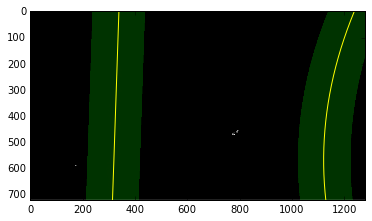

In [15]:
margin = 100

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
print(ploty.shape)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [16]:
def draw_polygon(img, left_fit, right_fit, Minv):
    blank = np.zeros_like(img).astype(np.uint8)

    fity = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
    right_fitx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_pts = np.array([np.transpose(np.vstack([left_fitx, fity]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])
    # stack left_pts and right_pts to be a single array
    pts = np.hstack((left_pts, right_pts))
    # saved in np array
    pts = np.array(pts, dtype=np.int32)
    # draw the plygon
    cv2.fillPoly(blank, pts, (0, 255, 0))

    # using inverse perspective matrix (Minv)
    unwapred = cv2.warpPerspective(blank, Minv, (img.shape[1], img.shape[0]))
    # Combine with the original image
    new_img = cv2.addWeighted(img, 1, unwapred, 0.3, 0)

    return new_img

(720, 1280, 3)


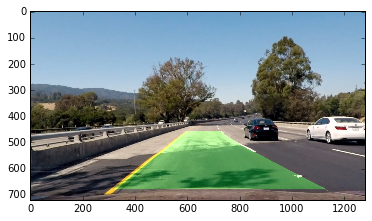

In [17]:
image = mpimg.imread('output_images/test_images/undistorted_test3.jpg')
newimg = draw_polygon(image, left_fit, right_fit, Minv)
plt.imshow(newimg, cmap='gray')
print(newimg.shape)

#### Calculating Curvature Radius and Estimating Vehicle Location

In [18]:
# calculating curvature radius in pixel and meter
# ploty = np.linspace(0, 719, num=720)
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
print(y_eval)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
print((ploty*ym_per_pix).shape)
print (left_fit)
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

719.0
369108.247464 1406.79505499
(720,)
[ -1.35710184e-06  -3.30189510e-02   3.38659447e+02]
121016.397179 m 454.145775142 m


In [19]:
# calculating the vehicle position w.r.t the lane lines
center_pixel = image.shape[1]/2
print(center_pixel)
print(left_fitx[0])
print(right_fitx[0])
# assuming camera is mounted at the center of the vehicle
vp_center = int((left_fitx[0]+right_fitx[0])/2)
print(vp_center)
from_center = center_pixel - vp_center
print(from_center)
vp_center_in_meter = xm_per_pix * from_center
print(vp_center_in_meter,'m')


640.0
338.659446599
1238.44572004
788
-148.0
-0.7822857142857144 m
